<a href="https://colab.research.google.com/github/Anurag-Singh-creator/attribution_modeling/blob/main/attribution_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install --upgrade pip
!pip install ChannelAttribution

import numpy as np
import pandas as pd
import datetime
import time
pd.options.mode.chained_assignment = None
import plotly.express as px

from ChannelAttribution import  heuristic_models, markov_model
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

import itertools
from collections import Counter, defaultdict
import re
import matplotlib.pyplot as plt
import requests
from PIL import Image
# for url
from urllib.parse import urlparse
from collections import OrderedDict

In [ ]:
# this is the focus sequencer data
# df = load_data('/content/drive/MyDrive/Dataz/manuel/bq-results-20230925-090747-1695633750190.csv')
# df.head(5)

# **Data Cleaning**

In [ ]:
def correct_journey(journey_str):
    if isinstance(journey_str, str):  # Check if the value is a string
        journey_str = journey_str.replace("faceboook|paid", "facebook|paid")  # Existing replacement
        journey_str = journey_str.replace("l.instagram.com", "instagram.com")  # New replacement
        return journey_str
    return journey_str  # Return the original value if not a string

def clean_journey(journey_str):
    if not isinstance(journey_str, str):  # Check if the value is a string
        return journey_str  # Return the original value if not a string

    # The following regex will match the specific substring followed or preceded by the '>' character.
    # It will then replace the match with nothing or with the '>' character respectively.
    cleaned_journey = re.sub(r'(?:^|>)checkout.stripe.com\|referral(>|$)|(^|>)billing.stripe.com\|referral(>|$)', r'\1', journey_str)

    # If after cleaning, the string is empty, return None (represents null)
    if not cleaned_journey:
        return None

    return cleaned_journey

def check_conversion(row):
    if row['Conversion'] =="Conversion":
        val = 1
    else:
        val = 0
    return val

-This is the function that loads the data for a given time period

-We are taking into account Manuels data

Following are the data ranges and the corresponding count of the data points in the originnal data:

```
2023-02    1077752
2023-03    1558979
2023-04    1138526
2023-05    1061704
2023-06     742657
2023-07     616669
2023-08     690847
2023-09     709807
Name: year_month, dtype: int64
```
We load a subset of this data by specifying a data range in the data loader function


Checking the time period/range of the dataset

# Data Loader

In [ ]:
def load_data_in_chunks(filepath, start_date_unix, end_date_unix, chunk_size=50000):
    """
    Load data in chunks for a given time period and concatenate them into a DataFrame.

    Parameters:
        filepath (str): Path to the file.
        start_date_unix (int): Start of the time period in UNIX timestamp.
        end_date_unix (int): End of the time period in UNIX timestamp.
        chunk_size (int): Number of rows per chunk.

    Returns:
        pd.DataFrame: Concatenated DataFrame for the given time period.
    """
    chunks = []
    for chunk in pd.read_csv(filepath, chunksize=chunk_size):
        filtered_chunk = chunk[(chunk['event_timestamp'] >= start_date_unix) & (chunk['event_timestamp'] < end_date_unix)]
        filtered_chunk = filtered_chunk[~(filtered_chunk['source_medium'].isna() & (filtered_chunk['event_name'] != "purchase"))]
        chunks.append(filtered_chunk)
    return pd.concat(chunks, ignore_index=True)

def load_filtered_data(filepath, given_month):
    """
    Load data for the specified month and the preceding month.

    Parameters:
        filepath (str): Path to the file.
        given_month (str): Month for which data is to be loaded in "YYYY/MM" format.

    Returns:
        pd.DataFrame: Concatenated DataFrame for the specified and preceding month.
    """
    # Convert year/month of the given_month to datetime object
    given_month_dt = datetime.datetime.strptime(given_month, "%Y/%m")

    # Calculate the UNIX timestamp for the first day of the given_month
    start_date_unix_given_month = time.mktime(given_month_dt.timetuple()) * 10**6

    # Get the first day of the next month
    next_month_dt = (given_month_dt.replace(day=28) + datetime.timedelta(days=4)).replace(day=1)

    # Subtract one second to get the last moment of the given_month
    end_unix_given_month = time.mktime(next_month_dt.timetuple()) * 10**6 - 1

    # Calculate the UNIX timestamp for the first day of the preceding month
    start_date_unix_preceding_month = time.mktime((given_month_dt - datetime.timedelta(days=1)).replace(day=1).timetuple()) * 10**6

    # Load data for the given_month and the preceding_month
    df_given_month = load_data_in_chunks(filepath, start_date_unix_given_month, end_unix_given_month)
    df_preceding_month = load_data_in_chunks(filepath, start_date_unix_preceding_month, start_date_unix_given_month)

    # Concatenate the data for the two months and return
    return pd.concat([df_given_month, df_preceding_month], ignore_index=True)


# Usage
# Load data for a specific month and the preceding month
given_month = "2023/09"
filepath = '/content/drive/MyDrive/Dataz/manuel/cleaned_data.csv'
df = load_filtered_data(filepath, given_month)


Check time priod

In [ ]:
# def check_time_range(df, start_unix, end_unix):
#     """
#     Check if the DataFrame contains records within a given time range.

#     Parameters:
#         df (pd.DataFrame): The DataFrame to check.
#         start_unix (int): The start of the desired time range in UNIX timestamp.
#         end_unix (int): The end of the desired time range in UNIX timestamp.

#     Returns:
#         bool: True if the DataFrame contains records within the time range, False otherwise.
#     """
#     # Find the minimum and maximum timestamps in the DataFrame
#     min_timestamp = df['event_timestamp'].min()
#     max_timestamp = df['event_timestamp'].max()

#     # Convert UNIX timestamps to human-readable string (day, month, and year)
#     min_time_str = datetime.datetime.utcfromtimestamp(min_timestamp / 10**6).strftime('%d-%m-%Y')
#     max_time_str = datetime.datetime.utcfromtimestamp(max_timestamp / 10**6).strftime('%d-%m-%Y')

#     # Check if the DataFrame contains records within the time range
#     is_within_range = (min_timestamp >= start_unix) and (max_timestamp <= end_unix)

#     # Print a message to inform the user about the time range check
#     if is_within_range:
#         print("The dataset contains records within the given time range.")
#     else:
#         print("The dataset does NOT contain records within the given time range.")

#     # Print the actual time range of the dataset in a human-readable string format
#     print(f"Actual time range in dataset: {min_time_str} to {max_time_str}")

#     return is_within_range

# # Usage example (assuming `df` is a DataFrame containing your data):
# # Check if the DataFrame contains records within a given time range
# # check_time_range(df, start_unix_preceding_month, end_unix_given_month)



# # Desired time range in "YYYY/MM" format
# given_month = "2023/04"
# preceding_month = "2023/03"

# # Convert year/month to datetime object
# given_month_dt = datetime.datetime.strptime(given_month, "%Y/%m")
# preceding_month_dt = datetime.datetime.strptime(preceding_month, "%Y/%m")

# # Calculate the UNIX timestamps
# start_unix_preceding_month = time.mktime(preceding_month_dt.timetuple()) * 10**6
# #start_unix_given_month = time.mktime(given_month_dt.timetuple()) * 10**6
# end_unix_given_month = time.mktime((given_month_dt + datetime.timedelta(days=31)).timetuple()) * 10**6

# # Check if the DataFrame contains records within the given time range
# check_time_range(df, start_unix_preceding_month, end_unix_given_month)


# **Journey Construction**

In [ ]:
def compute_user_journey(df):
    """
    Construct user journeys with the following rules:
    - Journeys are lists of tuples (source_medium, timestamp).
    - For non-conversion journeys, source_medium occurrences from preceding_month are excluded.
    - For conversion journeys, source_medium occurrences from up to 30 days before conversion are included.
    """
    df.sort_values(by=['user_pseudo_id', 'event_timestamp'], inplace=True)
    results = []
    journey = []
    conversion = "No Conversion"
    start_timestamp = None
    last_source_medium = None
    last_session_id = None
    last_event_timestamp = None

    for _, row in df.iterrows():
        current_source_medium = (row['source_medium'], row['event_timestamp'])  # Tuple (s_m, timestamp)

        # Initialize or update the journey
        if not journey:
            journey = [current_source_medium]
            start_timestamp = row['event_timestamp']
        else:
            # Append the source_medium to the journey if it's different from the last one
            # or if the ga_session_id has changed
            if current_source_medium[0] != last_source_medium[0] or row['ga_session_id'] != last_session_id:
                journey.append(current_source_medium)

        # Check if a conversion has occurred
        if row['event_name'] == 'purchase':
            conversion = "Conversion"

        # Logic to determine whether to save the current journey and start a new one
        end_of_journey = (
            len(journey) > 1 and
            (conversion == "Conversion" or (results and row['user_pseudo_id'] != results[-1]['user_pseudo_id']))
        )
        if end_of_journey:
            # Filtering logic: 30 days before the end of a journey (if it ends with conversion)
            if conversion == "Conversion":
                threshold_timestamp = last_event_timestamp - (30 * 24 * 60 * 60 * 10**6)  # 30 days in microseconds
                journey = [(s_m, t) for s_m, t in journey if t >= threshold_timestamp]
            results.append({
                'user_pseudo_id': row['user_pseudo_id'],
                'Journey': journey,
                'Conversion': conversion,
                'start_timestamp': start_timestamp
            })
            journey = [current_source_medium] if conversion == "Conversion" else []
            conversion = "No Conversion"
            start_timestamp = row['event_timestamp']

        # Update the last source_medium, last_session_id, and last_event_timestamp for the next iteration
        last_source_medium = current_source_medium
        last_session_id = row['ga_session_id']
        last_event_timestamp = row['event_timestamp']

    # Add the last journey to results if it's not empty
    if journey and (not results or row['user_pseudo_id'] == results[-1]['user_pseudo_id']):
        results.append({
            'user_pseudo_id': row['user_pseudo_id'],
            'Journey': journey,
            'Conversion': conversion,
            'start_timestamp': start_timestamp
        })

    return pd.DataFrame(results)

result_df = compute_user_journey(df)
result_df

,user_pseudo_id,Journey,Conversion,start_timestamp
0,+6ftMgUTAt92kdNp6xFhjRZKBlPC7Xl/tr8V6TcgOpY=.1...,"[(google|organic, 1693203708061034), (google|p...",Conversion,1693203708061034
1,+713BzmnSr2JJ5BCZA4RpldrpLoUT/cbcGnGYTr1yv0=.1...,"[(nan, 1690900486923019), (google|organic, 169...",No Conversion,1690900486923019
2,+739lMiTeueTmmJqU6RCDD9T2zoVvNnB7peIwXB2E6U=.1...,"[(l.instagram.com|referral, 1693296835695758),...",No Conversion,1693296835695758
3,+7E8etp7QOtXz1m9CjeHjBfOWehXVvvNmhTArZf8Tm4=.1...,"[(google|paid, 1693688722294173), (google|paid...",No Conversion,1693688722294173
4,+7OOkAFXxfvGdmvJ77Q7323Y/TYUqixnL/BC/YXu498=.1...,"[(google|paid, 1690978442181358), (newsletter|...",No Conversion,1690978442181358
...,...,...,...,...
64692,zzbeN0gzl+eb1UIwcs78x76Ekl8axq+CnElRZiX3pq8=.1...,"[(google|paid, 1694070781842826), (google|paid...",No Conversion,1694070781842826
64693,zzd6zw8WfgZlHU+WIu5j456V3WMBSW32n/z0Q5R27Zo=.1...,"[(google|paid, 1694452971876891), (facebook|pa...",No Conversion,1694452971876891
64694,zziFpetoWAVEfVB3UgkeS/ArujKHnwxmOSBP5AMtRbY=.1...,"[(facebook|paid, 1691437286105936), (google|pa...",No Conversion,1691437286105936
64695,zzwHgJlrDh11/PjoGFYSPhIiBv4SjkV8nr1HJtMU7kc=.1...,"[(google|paid, 1695248880026069), (google|paid...",No Conversion,1695248880026069


Check the longest journey

In [ ]:
# def find_longest_journey(df):
#     """
#     Find the journey with the maximum duration and display the journey and duration.

#     Parameters:
#         df (pd.DataFrame): DataFrame containing user journeys.

#     Returns:
#         pd.Series: The row of the journey with the maximum duration.
#         float: The duration of the longest journey in days.
#     """
#     max_duration = 0  # Initialize max_duration
#     max_duration_row = None  # Initialize the row with the maximum duration

#     for _, row in df.iterrows():
#         journey = row['Journey']
#         if journey:  # Check if the journey is not empty
#             # Extract the timestamps from the journey
#             timestamps = [t for _, t in journey]
#             duration = (timestamps[-1] - timestamps[0]) / (10**6 * 60 * 60 * 24)  # Convert microseconds to days

#             # Update max_duration and max_duration_row if the current duration is larger
#             if duration > max_duration:
#                 max_duration = duration
#                 max_duration_row = row

#     # Display the results
#     if max_duration_row is not None:
#         print(f"Longest journey: {max_duration_row['Journey']}")
#         print(f"Conversion: {max_duration_row['Conversion']}")
#         print(f"Duration: {max_duration:.2f} days")
#     else:
#         print("No journeys found.")

#     return max_duration_row, max_duration


# # Example usage
# longest_journey_row, longest_journey_duration = find_longest_journey(result_df)
# print(longest_journey_row)
# print(longest_journey_duration)

In [ ]:

def transform_journeys(journeys_df, start_unix_given_month, end_unix_given_month):
    """
    Transform user journeys with the following rules:
    - For non-conversion journeys, keep source_medium occurrences only from the given_month.
    - For conversion journeys, keep them as is, unless the last timestamp is not within
      the given_month, in which case, remove them.

    Parameters:
        journeys_df (pd.DataFrame): DataFrame containing user journeys.
        start_unix_given_month (int): Unix timestamp of the first day of the given_month.
        end_unix_given_month (int): Unix timestamp of the last day of the given_month.

    Returns:
        pd.DataFrame: DataFrame containing the transformed journeys.
    """
    transformed_journeys = []

    for _, row in journeys_df.iterrows():
        journey = row['Journey']

        # For non-conversion journeys, keep only source_medium occurrences from the given_month
        if row['Conversion'] == 'No Conversion':
            journey = [(s_m, t) for s_m, t in journey if t >= start_unix_given_month]
        # For conversion journeys, check if the last timestamp is within the given_month
        elif row['Conversion'] == 'Conversion' and journey:
            _, last_timestamp = journey[-1]
            if not (start_unix_given_month <= last_timestamp <= end_unix_given_month):
                continue

        transformed_journeys.append({
            'user_pseudo_id': row['user_pseudo_id'],
            'Journey': journey,
            'Conversion': row['Conversion'],
            'start_timestamp': row['start_timestamp']
        })

    return pd.DataFrame(transformed_journeys)

given_month_dt = datetime.datetime.strptime(given_month, "%Y/%m")
start_date_unix_given_month = int(given_month_dt.timestamp() * 10**6)

# Get the first day of the next month
next_month_dt = (given_month_dt.replace(day=28) + datetime.timedelta(days=4)).replace(day=1)
# Subtract one second to get the last moment of the given_month
end_unix_given_month = int(next_month_dt.timestamp() * 10**6) - 1

# Assuming result_df is obtained from compute_user_journey function
transformed_journeys_df = transform_journeys(result_df, start_date_unix_given_month, end_unix_given_month)

transformed_journeys_df

,user_pseudo_id,Journey,Conversion,start_timestamp
0,+713BzmnSr2JJ5BCZA4RpldrpLoUT/cbcGnGYTr1yv0=.1...,[],No Conversion,1690900486923019
1,+739lMiTeueTmmJqU6RCDD9T2zoVvNnB7peIwXB2E6U=.1...,"[(google|paid, 1693688722294173)]",No Conversion,1693296835695758
2,+7E8etp7QOtXz1m9CjeHjBfOWehXVvvNmhTArZf8Tm4=.1...,"[(google|paid, 1693688722294173)]",No Conversion,1693688722294173
3,+7OOkAFXxfvGdmvJ77Q7323Y/TYUqixnL/BC/YXu498=.1...,[],No Conversion,1690978442181358
4,+7d4a1i0LoTOx1m96AqpS9oEGFapvMnz/3BDRULYI7A=.1...,"[(facebook|paid, 1695114624410031)]",No Conversion,1691840119013309
...,...,...,...,...
64274,zzbeN0gzl+eb1UIwcs78x76Ekl8axq+CnElRZiX3pq8=.1...,"[(google|paid, 1694070781842826), (google|paid...",No Conversion,1694070781842826
64275,zzd6zw8WfgZlHU+WIu5j456V3WMBSW32n/z0Q5R27Zo=.1...,"[(google|paid, 1694452971876891)]",No Conversion,1694452971876891
64276,zziFpetoWAVEfVB3UgkeS/ArujKHnwxmOSBP5AMtRbY=.1...,"[(google|paid, 1695248880026069)]",No Conversion,1691437286105936
64277,zzwHgJlrDh11/PjoGFYSPhIiBv4SjkV8nr1HJtMU7kc=.1...,"[(google|paid, 1695248880026069), (google|paid...",No Conversion,1695248880026069


In [ ]:
def convert_journey_to_string(journeys_df):
    """
    Convert journeys from list of tuples format to string format ("s_m1 > s_m2 > ...").

    Parameters:
        journeys_df (pd.DataFrame): DataFrame containing user journeys.

    Returns:
        pd.DataFrame: DataFrame containing the journeys in string format.
    """
    string_journeys = []

    for _, row in journeys_df.iterrows():
        # Safely convert source_medium to string and exclude 'nan' or NaN values
        journey_str = ' > '.join([str(s_m) for s_m, _ in row['Journey'] if pd.notna(s_m) and str(s_m).lower() != 'nan'])
        string_journeys.append({
            'user_pseudo_id': row['user_pseudo_id'],
            'Journey': journey_str,
            'Conversion': row['Conversion'],
            'start_timestamp': row['start_timestamp']
        })

    return pd.DataFrame(string_journeys)


# Convert the journeys to string format
string_journeys_df = convert_journey_to_string(transformed_journeys_df)

# Display the result


If you want to save the result_df then run the following command

In [ ]:
#result_df.to_csv('test_1_result.csv', index=False)

# **Attribution Model**
###-Markov Chain

###-Last Touch

<ipython-input-93-b3819aeb84fd>:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  attribution_df = df.groupby(['Journey'], as_index=False).sum()


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 2.45% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


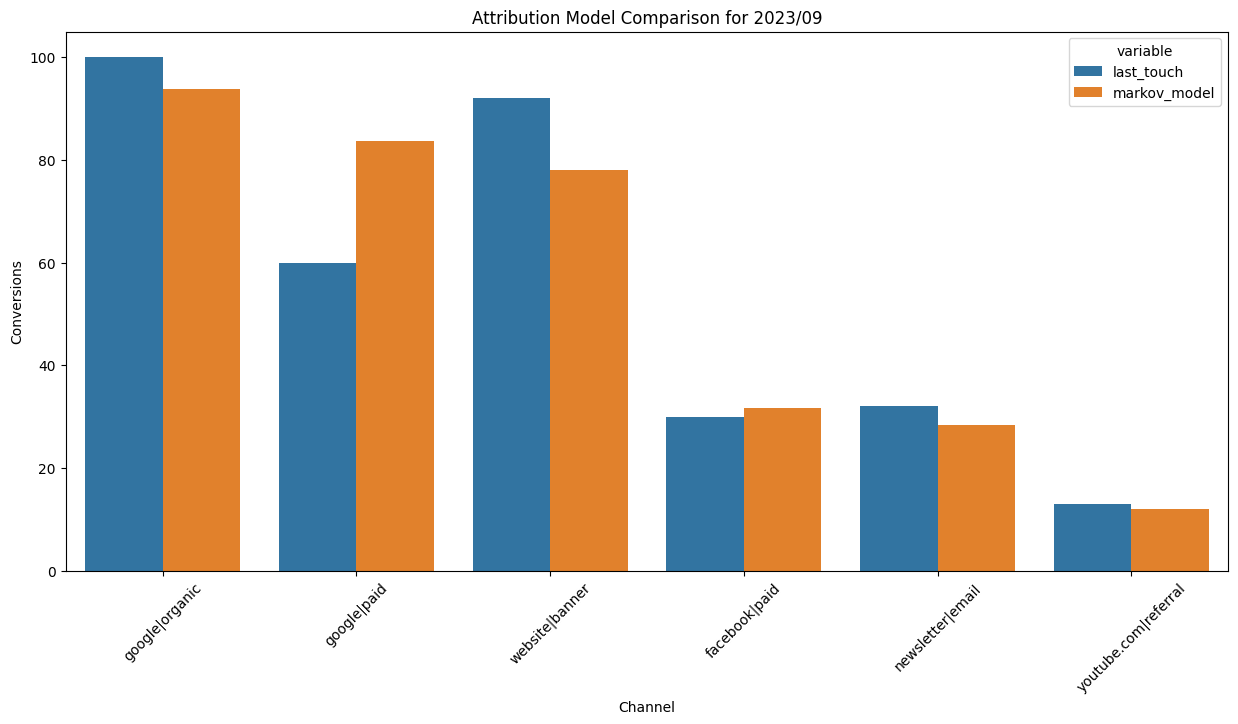

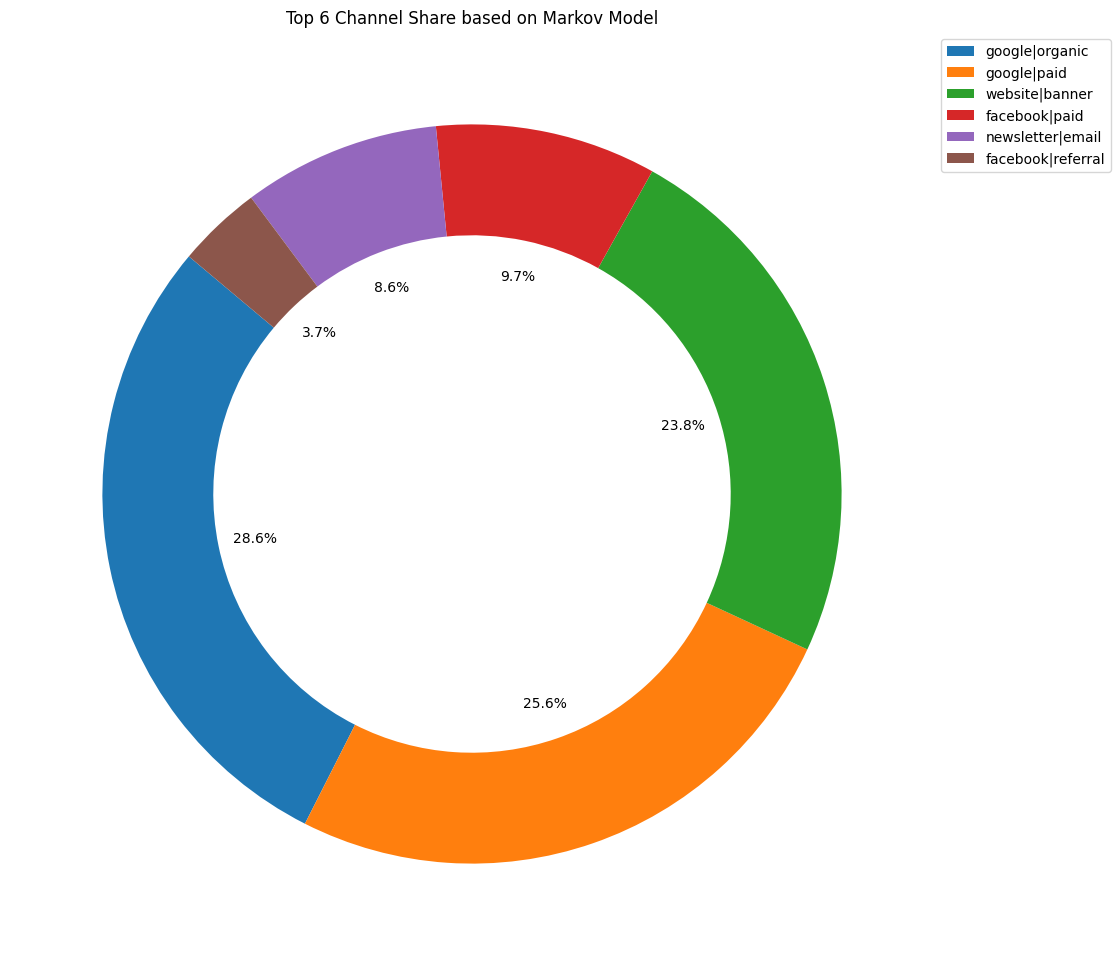

In [ ]:
def preprocess_data(df):
    # Conversion calculation (assuming check_conversion is defined elsewhere)
    df['Conversion'] = df.apply(check_conversion, axis=1)

    # Convert Journey elements to lowercase, ensuring they are strings first
    df['Journey'] = df['Journey'].apply(lambda x: str(x).lower() if pd.notnull(x) else x)

    # Correct the Journey column values
    df['Journey'] = df['Journey'].apply(correct_journey)

    # Clean the Journey column values using the new function
    df['Journey'] = df['Journey'].apply(clean_journey)

    # Other preprocessing
 #   df.drop(columns=['user_pseudo_id', 'start_timestamp'], axis=1, inplace=True)
    df['null'] = np.where(df['Conversion'] == 0, 1, 0)

    return df

def calculate_attribution(df):
    assert 'Conversion' in df.columns, "'Conversion' column not found in df"
    assert df['Conversion'].sum() > 0, "'Conversion' column sums to zero or NaN"

    # Filter out rows where Journey contains "checkout.stripe.com"
    df = df[~df['Journey'].str.contains('checkout.stripe.com', na=False)]

    attribution_df = df.groupby(['Journey'], as_index=False).sum()
    attribution_df.rename(columns={
        "Conversion": "total_conversions",
        "null": "total_null",
        "conversion_value_euro": "total_conversion_value"
    }, inplace=True)
    H = heuristic_models(attribution_df, "Journey", "total_conversions")

    # Extracting Last Touch Attribution
    last_touch = H[['channel_name', 'last_touch']]
    last_touch.columns = ['channel_name', 'last_touch']

    M = markov_model(attribution_df, "Journey", "total_conversions")
    M = M[['channel_name', 'total_conversions']]
    M.columns = ['channel_name', 'markov_model']

    # Merging the two dataframes based on the channel name
    R = pd.merge(last_touch, M, on="channel_name", how="inner")

    return pd.melt(R, id_vars="channel_name")


def plot_data(data, top_n, date_str):
    # Select top_n values
    top_channels = data.sort_values('value', ascending=False)['channel_name'].unique()[:top_n]
    data = data[data['channel_name'].isin(top_channels)]

    plt.figure(figsize=(15, 7))
    sns.barplot(data=data, x='channel_name', y='value', hue='variable')
    plt.title(f'Attribution Model Comparison for {date_str}')
    plt.ylabel('Conversions')
    plt.xlabel('Channel')
    plt.xticks(rotation=45)  # Tilt the x-axis labels
    plt.show()


def plot_pie_chart(data, top_n):
    # Assuming 'markov_model' results for the pie chart
    markov_data = data[data['variable'] == 'markov_model']

    # Sort data to get the top channels based on 'value'
    markov_data = markov_data.sort_values(by='value', ascending=False).head(top_n)

    # Increase chart size if needed
    plt.figure(figsize=(12, 12))

    # Plot the pie chart with labels outside the pie and add a legend
    plt.pie(markov_data['value'], autopct='%1.1f%%', startangle=140,
            wedgeprops=dict(width=0.3), labeldistance=1.05)

    plt.legend(markov_data['channel_name'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Top {} Channel Share based on Markov Model'.format(top_n))
    plt.show()


def main_analysis(result_df, top_n, start_date_str=None, end_date_str=None):
    df = preprocess_data(result_df)
    data_to_plot = calculate_attribution(df)

    # Construct date_str elegantly
    if start_date_str and end_date_str and start_date_str != end_date_str:
        date_str = f"{start_date_str} to {end_date_str}"
    elif start_date_str:
        date_str = start_date_str
    elif end_date_str:
        date_str = end_date_str
    else:
        date_str = "All Available Data"

    plot_data(data_to_plot, top_n, date_str)
    plot_pie_chart(data_to_plot, top_n)

# Usage example
start_date_str = given_month
end_date_str = start_date_str
df = main_analysis(string_journeys_df, top_n=6, start_date_str=start_date_str, end_date_str=end_date_str)
